In [ ]:
# 1. 필수 라이브러리 설치 (gensim, konlpy 등 포함)
!pip install pandas konlpy gensim numpy

# 2. Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.9/495.9 kB 28.9 MB/s eta 0:00:00
Mounted at /content/drive


파일 수: 461
전체 행 수: 175571
컬럼: ['ISBN', 'site', 'title_norm', 'file_title', 'review_text', 'rating_5pt', 'review_date', 'tokens', 'tokens_lemma', 'sentiment_tokens', 'sentiment_lemmas', 'sent_score', 'sent_matched_cnt', 'sent_pos_cnt', 'sent_neg_cnt', 'sent_matched_terms', 'sent_len', 'sent_match_rate', 'sent_binary', 'file', 'n_rows', 'avg_score', 'pos_ratio(=1)', 'neg_ratio(=0)', 'avg_match_rate']
분석에 사용된 행 수: 175110


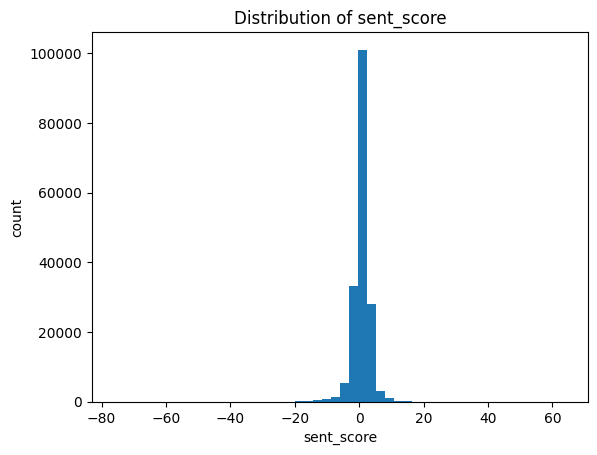

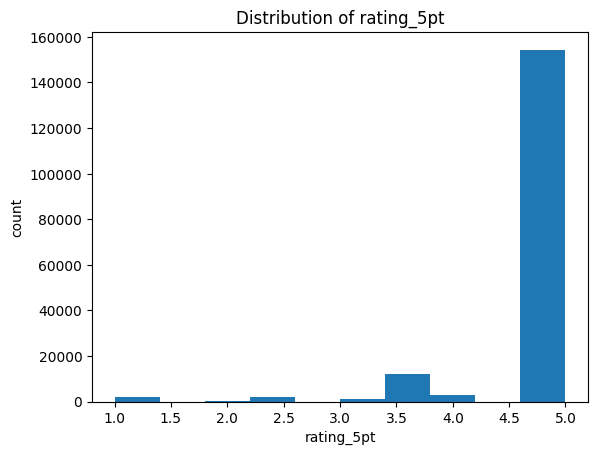

Pearson: 0.10774509592651269
Spearman: 0.09969610675165358


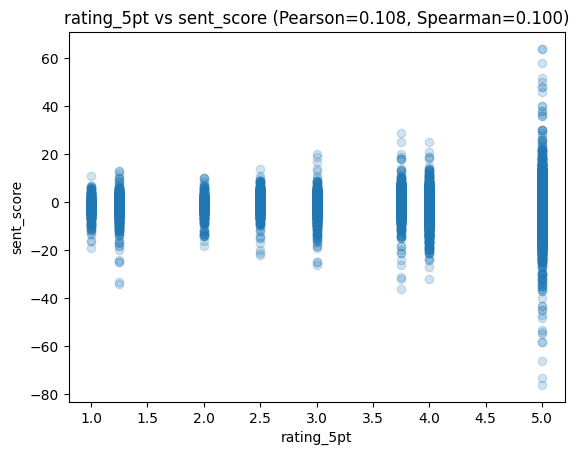

In [ ]:
import os, glob
import pandas as pd
import matplotlib.pyplot as plt

PROJECT_BASE = "/content/drive/MyDrive/텍마팀플/project"
REVIEW_DIR   = f"{PROJECT_BASE}/리뷰DB_scored"

# 1) 전체 리뷰(scored) 파일 로드
files = sorted(glob.glob(os.path.join(REVIEW_DIR, "*.csv")))
print("파일 수:", len(files))

def read_csv_flexible(path):
    for enc in ["utf-8-sig", "utf-8", "cp949", "euc-kr"]:
        try:
            return pd.read_csv(path, encoding=enc)
        except:
            pass
    return pd.read_csv(path, encoding="cp949", errors="replace")

dfs = []
for path in files:
    df = read_csv_flexible(path)
    dfs.append(df)

all_reviews = pd.concat(dfs, ignore_index=True)
print("전체 행 수:", len(all_reviews))
print("컬럼:", all_reviews.columns.tolist())

# 2) 필요한 컬럼 정리(숫자형 변환)
#    - 평점 컬럼명이 다르면 여기만 바꾸면 됩니다.
RATING_COL = "rating_5pt"
SENT_COL   = "sent_score"
BIN_COL    = "sent_binary"

all_reviews[RATING_COL] = pd.to_numeric(all_reviews.get(RATING_COL), errors="coerce")
all_reviews[SENT_COL]   = pd.to_numeric(all_reviews.get(SENT_COL), errors="coerce")
all_reviews[BIN_COL]    = pd.to_numeric(all_reviews.get(BIN_COL), errors="coerce")

dfv = all_reviews[[RATING_COL, SENT_COL, BIN_COL]].dropna()
print("분석에 사용된 행 수:", len(dfv))

# 3) (A) 감성점수 분포 시각화
plt.figure()
plt.hist(dfv[SENT_COL], bins=50)
plt.title("Distribution of sent_score")
plt.xlabel("sent_score")
plt.ylabel("count")
plt.show()

# 4) (B) 평점 분포 시각화
plt.figure()
plt.hist(dfv[RATING_COL], bins=10)
plt.title("Distribution of rating_5pt")
plt.xlabel("rating_5pt")
plt.ylabel("count")
plt.show()

# 5) (C) 평점-감성점수 상관관계 시각화 + 상관계수
pearson = dfv[[RATING_COL, SENT_COL]].corr(method="pearson").iloc[0,1]
spearman = dfv[[RATING_COL, SENT_COL]].corr(method="spearman").iloc[0,1]
print("Pearson:", pearson)
print("Spearman:", spearman)

plt.figure()
plt.scatter(dfv[RATING_COL], dfv[SENT_COL], alpha=0.2)
plt.title(f"rating_5pt vs sent_score (Pearson={pearson:.3f}, Spearman={spearman:.3f})")
plt.xlabel("rating_5pt")
plt.ylabel("sent_score")
plt.show()


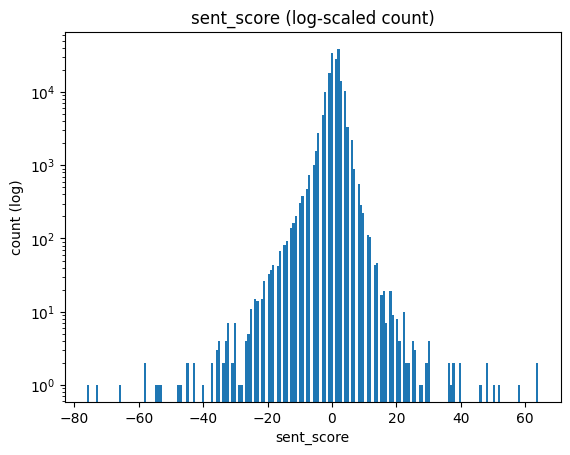

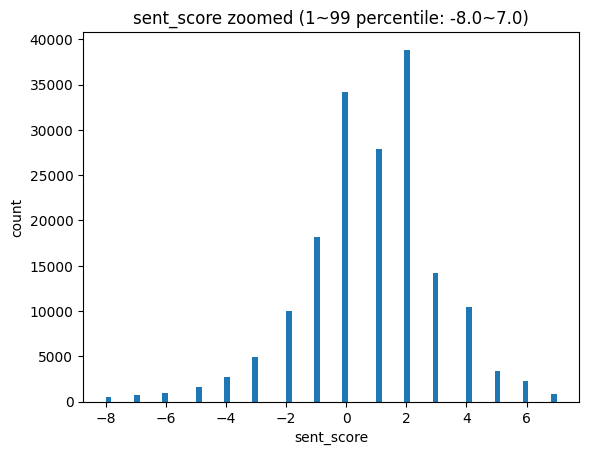

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = dfv["sent_score"].dropna()

# (A) 전체(꼬리 포함) - 로그축
plt.figure()
plt.hist(x, bins=200, log=True)
plt.title("sent_score (log-scaled count)")
plt.xlabel("sent_score"); plt.ylabel("count (log)")
plt.show()

# (B) 중앙 98% 구간만 확대(극단치 영향 제거)
lo, hi = np.percentile(x, [1, 99])
x_mid = x[(x >= lo) & (x <= hi)]

plt.figure()
plt.hist(x_mid, bins=80)
plt.title(f"sent_score zoomed (1~99 percentile: {lo:.1f}~{hi:.1f})")
plt.xlabel("sent_score"); plt.ylabel("count")
plt.show()


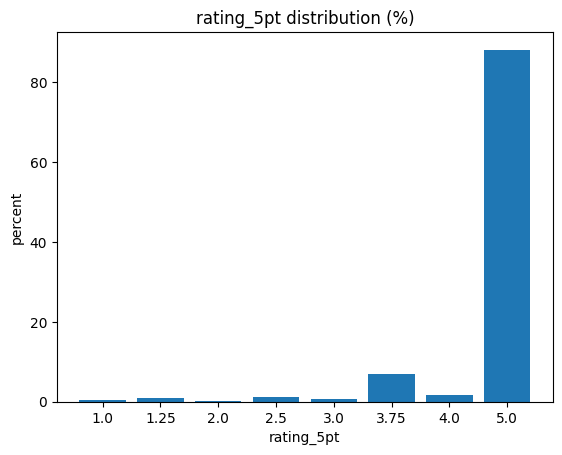

In [ ]:
import matplotlib.pyplot as plt

r = dfv["rating_5pt"].dropna()
ratio = (r.value_counts(normalize=True).sort_index() * 100)

plt.figure()
plt.bar(ratio.index.astype(str), ratio.values)
plt.title("rating_5pt distribution (%)")
plt.xlabel("rating_5pt"); plt.ylabel("percent")
plt.show()


In [ ]:
import os, glob, ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

PROJECT_BASE = "/content/drive/MyDrive/텍마팀플/project"
REVIEW_DIR   = f"{PROJECT_BASE}/리뷰DB_scored"
BOOK_DIR     = f"{PROJECT_BASE}/도서DB"
YEARS = [2020, 2021, 2022, 2023, 2024]

# -------------------------
# 0) 도서DB(xlsx) 자동 선택 + 리뷰DB 로드
# -------------------------
xlsx_list = sorted(glob.glob(os.path.join(BOOK_DIR, "*.xlsx")))
print("xlsx_list:", xlsx_list)
BOOK_DB_PATH = xlsx_list[0]
print("BOOK_DB_PATH:", BOOK_DB_PATH)

book_df = pd.read_excel(BOOK_DB_PATH)
print("book_df columns:", list(book_df.columns))

review_files = sorted(glob.glob(os.path.join(REVIEW_DIR, "*.csv")))
print("n_review_files:", len(review_files))

dfs = []
for fp in review_files:
    try:
        d = pd.read_csv(fp, encoding="utf-8-sig")
    except:
        d = pd.read_csv(fp, encoding="cp949")
    d["__src_file"] = os.path.basename(fp)
    dfs.append(d)

review_df = pd.concat(dfs, ignore_index=True)
print("review_df columns:", list(review_df.columns))

# -------------------------
# 공통: 연도/평점 숫자화
# -------------------------
review_df["review_date_dt"] = pd.to_datetime(review_df["review_date"], errors="coerce", infer_datetime_format=True)
review_df["year"] = review_df["review_date_dt"].dt.year
review_df["rating_5pt"] = pd.to_numeric(review_df["rating_5pt"], errors="coerce")


xlsx_list: ['/content/drive/MyDrive/텍마팀플/project/도서DB/bestseller_DB(20-24).xlsx', '/content/drive/MyDrive/텍마팀플/project/도서DB/bestseller_DB(20-24)_titleNorm.xlsx']
BOOK_DB_PATH: /content/drive/MyDrive/텍마팀플/project/도서DB/bestseller_DB(20-24).xlsx
book_df columns: ['ISBN', 'title', 'author', 'publisher', 'pub_date', 'category', 'aladin_productcode', 'kyobo_productcode', 'best_aladin_rank', 'best_kyobo_rank', 'bestseller_year', 'first_bestseller_year', 'last_bestseller_year', 'n_bestseller_years', 'aladin_rank_by_year', 'kyobo_rank_by_year']
n_review_files: 461
review_df columns: ['ISBN', 'site', 'title_norm', 'file_title', 'review_text', 'rating_5pt', 'review_date', 'tokens', 'tokens_lemma', 'sentiment_tokens', 'sentiment_lemmas', 'sent_score', 'sent_matched_cnt', 'sent_pos_cnt', 'sent_neg_cnt', 'sent_matched_terms', 'sent_len', 'sent_match_rate', 'sent_binary', '__src_file', 'file', 'n_rows', 'avg_score', 'pos_ratio(=1)', 'neg_ratio(=0)', 'avg_match_rate']


/tmp/ipython-input-2299070512.py:40: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  review_df["review_date_dt"] = pd.to_datetime(review_df["review_date"], errors="coerce", infer_datetime_format=True)


In [ ]:
# 0) 한글 폰트 설정 (Colab)
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 나눔고딕 설치/적용
!apt-get -qq -y install fonts-nanum > /dev/null
plt.rcParams["font.family"] = "NanumGothic"
plt.rcParams["axes.unicode_minus"] = False


In [ ]:
# Colab 한글 폰트 "확실하게" 적용 (NanumGothic 안 잡히는 경우까지 포함)
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os, glob

!apt-get -qq update > /dev/null
!apt-get -qq -y install fonts-nanum fonts-noto-cjk > /dev/null

# 설치된 한글 폰트 파일 경로 찾아서 직접 지정
font_candidates = []
font_candidates += glob.glob("/usr/share/fonts/truetype/nanum/*.ttf")
font_candidates += glob.glob("/usr/share/fonts/opentype/noto/*.otf")
font_candidates += glob.glob("/usr/share/fonts/truetype/noto/*.ttf")

print("font_candidates sample:", font_candidates[:5])

font_path = None
# 우선순위: 나눔고딕 > 노토산 CJK
for p in font_candidates:
    if "NanumGothic" in os.path.basename(p):
        font_path = p
        break
if font_path is None and len(font_candidates) > 0:
    font_path = font_candidates[0]

print("selected font_path:", font_path)

if font_path is not None:
    fm.fontManager.addfont(font_path)
    font_name = fm.FontProperties(fname=font_path).get_name()
    plt.rcParams["font.family"] = font_name

plt.rcParams["axes.unicode_minus"] = False
print("matplotlib font.family:", plt.rcParams["font.family"])


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
font_candidates sample: ['/usr/share/fonts/truetype/nanum/NanumGothicCodingBold.ttf', '/usr/share/fonts/truetype/nanum/NanumGothic.ttf', '/usr/share/fonts/truetype/nanum/NanumSquareB.ttf', '/usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf', '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf']
selected font_path: /usr/share/fonts/truetype/nanum/NanumGothicCodingBold.ttf
matplotlib font.family: ['NanumGothicCoding']


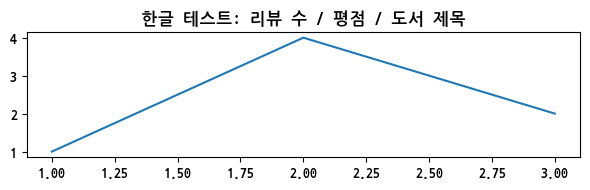

In [ ]:
# (폰트 적용 확인용 테스트)
plt.figure(figsize=(6,2))
plt.title("한글 테스트: 리뷰 수 / 평점 / 도서 제목")
plt.plot([1,2,3],[1,4,2])
plt.tight_layout()
plt.show()


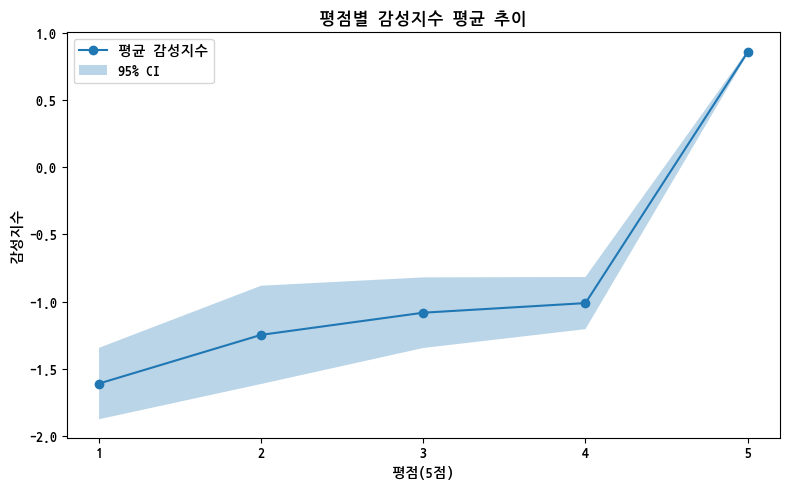

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

sent_col = sent_col  # 앞에서 찾은 감성지수 컬럼
tmp = review_df[["rating_5pt", sent_col]].dropna()
tmp = tmp[tmp["rating_5pt"].isin([1,2,3,4,5])]

stats = (
    tmp.groupby("rating_5pt")[sent_col]
       .agg(["mean", "std", "count"])
       .reset_index()
)

stats["se"] = stats["std"] / np.sqrt(stats["count"])
stats["ci95"] = 1.96 * stats["se"]

plt.figure(figsize=(8,5))

# 평균선
plt.plot(stats["rating_5pt"], stats["mean"], marker="o", label="평균 감성지수")

# 신뢰구간 밴드
plt.fill_between(
    stats["rating_5pt"],
    stats["mean"] - stats["ci95"],
    stats["mean"] + stats["ci95"],
    alpha=0.3,
    label="95% CI"
)

plt.xlabel("평점(5점)")
plt.ylabel("감성지수")
plt.title("평점별 감성지수 평균 추이")
plt.xticks([1,2,3,4,5])
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt

YEARS = [2020, 2021, 2022, 2023, 2024]

def parse_year_list(x):
    if pd.isna(x): return []
    if isinstance(x, list):
        out=[]
        for t in x:
            try: out.append(int(t))
            except: pass
        return out
    s = str(x).strip()
    if s == "" or s == "[]": return []
    try:
        v = ast.literal_eval(s)
        if isinstance(v, list):
            out=[]
            for t in v:
                try: out.append(int(t))
                except: pass
            return out
    except:
        pass
    out=[]
    for tok in s.replace("[","").replace("]","").split(","):
        tok = tok.strip()
        if tok.isdigit(): out.append(int(tok))
    return out

# 감성 컬럼
sent_col = None
for c in ["sent_score","sentiment_score","sentiment_index","senti_score","polarity_score","emotion_score"]:
    if c in review_df.columns:
        sent_col = c
        break
print("sent_col:", sent_col)

review_df["rating_5pt"] = pd.to_numeric(review_df["rating_5pt"], errors="coerce")
if sent_col:
    review_df[sent_col] = pd.to_numeric(review_df[sent_col], errors="coerce")

# 길이 컬럼
len_col = "len_tokens" if "len_tokens" in review_df.columns else ("len_chars" if "len_chars" in review_df.columns else None)
print("len_col:", len_col)

# 책별 베스트셀러 연도
b = book_df[["ISBN","bestseller_year"]].drop_duplicates("ISBN").copy()
b["year_list"] = b["bestseller_year"].apply(parse_year_list)
b["n_bestseller_years"] = b["year_list"].apply(len)
b["first_year"] = b["year_list"].apply(lambda L: min(L) if len(L)>0 else np.nan)

# 책별 리뷰 집계
agg_dict = {
    "n_reviews": ("ISBN","size"),
    "avg_rating": ("rating_5pt","mean"),
}
if sent_col:
    agg_dict["avg_sent"] = (sent_col,"mean")
if len_col:
    agg_dict["avg_len"] = (len_col,"mean")

agg = (review_df.groupby("ISBN").agg(**agg_dict).reset_index())
m = b.merge(agg, on="ISBN", how="left")

for c in ["n_reviews","avg_rating","avg_sent","avg_len"]:
    if c in m.columns:
        m[c] = m[c].fillna(0)

m["reviews_per_year"] = m["n_reviews"] / m["n_bestseller_years"].replace(0, np.nan)

# 그룹 정의
steady = m[m["n_bestseller_years"] >= 4].copy()
trend  = m[(m["n_bestseller_years"] == 1) & (m["first_year"] <= 2022)].copy()

steady["group"] = "스테디(4-5년)"
trend["group"]  = "트렌드(1년)"

comp = pd.concat([steady, trend], ignore_index=True)
print("steady n_books:", steady.shape[0])
print("trend  n_books:", trend.shape[0])

# 비교표
cols = ["group","ISBN","n_bestseller_years","n_reviews","reviews_per_year","avg_rating"]
if sent_col: cols.append("avg_sent")
if len_col: cols.append("avg_len")

summary = (comp.groupby("group")
           .agg(n_books=("ISBN","count"),
                mean_n_reviews=("n_reviews","mean"),
                mean_reviews_per_year=("reviews_per_year","mean"),
                mean_rating=("avg_rating","mean"),
                mean_sent=("avg_sent","mean") if sent_col else ("avg_rating","mean"),
                mean_len=("avg_len","mean") if len_col else ("avg_rating","mean"))
          )
summary


sent_col: sent_score
len_col: len_tokens
steady n_books: 16
trend  n_books: 210


,n_books,mean_n_reviews,mean_reviews_per_year,mean_rating,mean_sent,mean_len
group,,,,,,
스테디(4-5년),16,1466.062500,318.765625,4.839177,0.749377,6.735804
트렌드(1년),210,283.295238,283.295238,4.641374,0.734811,8.645364


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
selected font_path: /usr/share/fonts/truetype/nanum/NanumGothicCodingBold.ttf
matplotlib font.family: ['NanumGothicCoding']


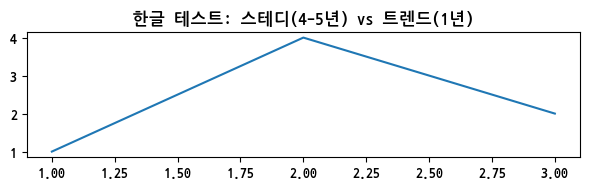

In [ ]:
# 한글 깨짐/물음표/네모 해결: 폰트를 "파일 경로로" 강제 지정 + matplotlib 캐시 갱신
import os, glob
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

!apt-get -qq update > /dev/null
!apt-get -qq -y install fonts-nanum fonts-noto-cjk > /dev/null

# 후보 폰트 경로 수집
cands = []
cands += glob.glob("/usr/share/fonts/truetype/nanum/*.ttf")
cands += glob.glob("/usr/share/fonts/opentype/noto/*.otf")
cands += glob.glob("/usr/share/fonts/truetype/noto/*.ttf")

# 우선순위 선택
font_path = None
for p in cands:
    if "NanumGothic" in os.path.basename(p):
        font_path = p
        break
if font_path is None:
    for p in cands:
        if "NotoSansCJK" in os.path.basename(p) or "NotoSansCJKkr" in os.path.basename(p) or "NotoSansKR" in os.path.basename(p):
            font_path = p
            break
if font_path is None and len(cands) > 0:
    font_path = cands[0]

print("selected font_path:", font_path)

# 폰트 등록/적용
if font_path is not None:
    fm.fontManager.addfont(font_path)
    font_name = fm.FontProperties(fname=font_path).get_name()
    plt.rcParams["font.family"] = font_name

plt.rcParams["axes.unicode_minus"] = False
print("matplotlib font.family:", plt.rcParams["font.family"])

# 테스트
plt.figure(figsize=(6,2))
plt.title("한글 테스트: 스테디(4-5년) vs 트렌드(1년)")
plt.plot([1,2,3],[1,4,2])
plt.tight_layout()
plt.show()


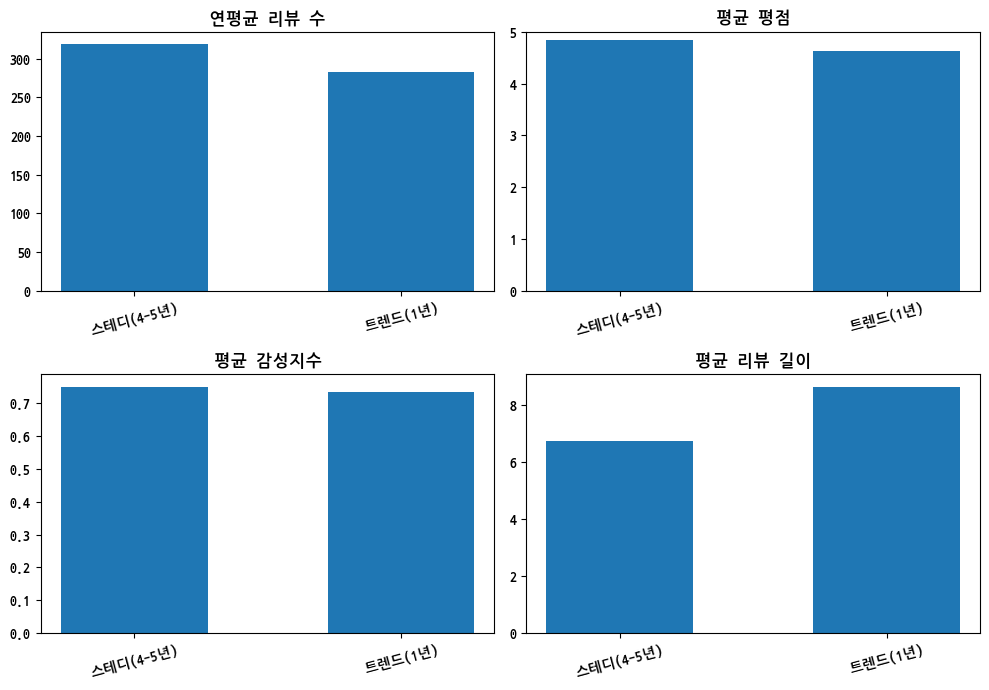

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

labels = ["스테디(4-5년)", "트렌드(1년)"]
x = np.arange(2)
bar_w = 0.55  # 두께

fig, axes = plt.subplots(2, 2, figsize=(10,7))

def draw_bar(ax, values, title, ylim=None):
    ax.bar(x, values, width=bar_w)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=15)

    # 핵심: x축 범위를 좁혀서 여백 제거
    ax.set_xlim(-0.35, 1.35)   # 숫자 조절하면 더 촘촘/여유 조절됨

    if ylim is not None:
        ax.set_ylim(*ylim)

draw_bar(axes[0,0], plot_df.loc[labels, "mean_reviews_per_year"].values, "연평균 리뷰 수")
draw_bar(axes[0,1], plot_df.loc[labels, "mean_rating"].values, "평균 평점", ylim=(0,5))
draw_bar(axes[1,0], plot_df.loc[labels, "mean_sent"].values, "평균 감성지수")
draw_bar(axes[1,1], plot_df.loc[labels, "mean_len"].values, "평균 리뷰 길이")

plt.tight_layout()
plt.show()
